In [1]:
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from filterpy.kalman import KalmanFilter

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image as IPImage

p_imu = Path('/data/datasets/ego4d_data/v2/imu/0ce20f1b-104c-48aa-a957-75f772238639.csv')
df = pd.read_csv(p_imu, index_col=0).dropna()
df = df.sort_values('canonical_timestamp_ms')
del df['component_timestamp_ms']
df = df[['accl_x', 'accl_y', 'accl_z', 'gyro_x', 'gyro_y', 'gyro_z', 'canonical_timestamp_ms']].reset_index(drop=True)
# median filter
df = df.rolling(20).median().dropna()
df

,accl_x,accl_y,accl_z,gyro_x,gyro_y,gyro_z,canonical_timestamp_ms
19,5.399522,1.586124,7.935407,-0.550586,0.969915,-0.563632,50.399971
20,5.418660,1.586124,7.964115,-0.550586,0.993078,-0.577476,55.690977
21,5.433014,1.586124,7.992823,-0.550586,1.018903,-0.588924,60.981982
22,5.442584,1.586124,8.064593,-0.550586,1.046060,-0.604366,66.272987
23,5.480861,1.562201,8.165072,-0.550586,1.080138,-0.616081,71.563993
...,...,...,...,...,...,...,...
56226,6.543062,3.021531,6.959330,0.204473,0.199947,0.162673,286189.612426
56227,6.519139,3.088517,6.944976,0.185570,0.199681,0.162673,286194.740631
56228,6.504785,3.126794,6.916268,0.161874,0.199148,0.161874,286199.868836
56229,6.476077,3.136364,6.849282,0.138445,0.197018,0.156283,286204.997041


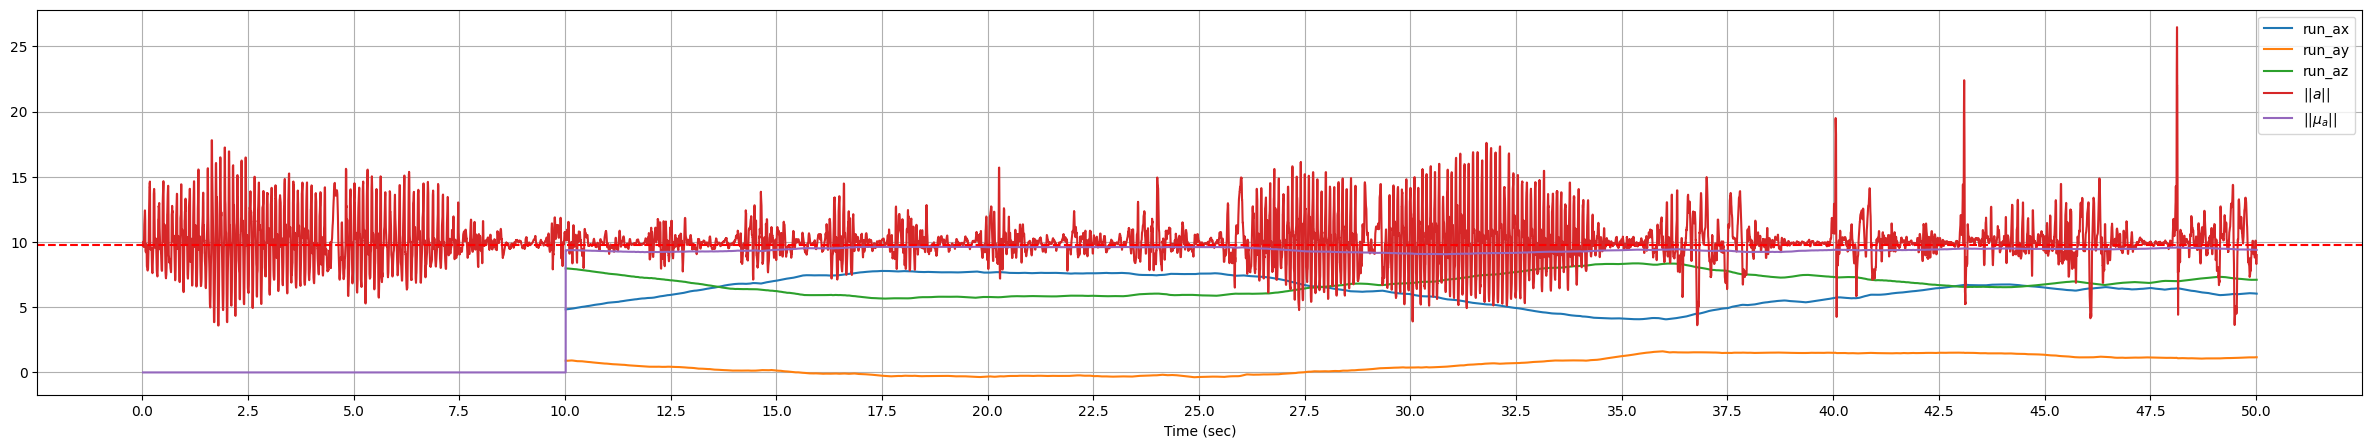

In [27]:
n = 50000
fig = plt.figure(figsize=(30, 5))
df_head = df.head(n)[['accl_x', 'accl_y', 'accl_z']].copy()
df_head[r'$|| a ||$'] = (df_head[['accl_x', 'accl_y', 'accl_z']] ** 2).sum(axis=1).apply(lambda x: x ** 0.5)
df_head[['run_ax', 'run_ay', 'run_az']] = df_head[['accl_x', 'accl_y', 'accl_z']].rolling(10000).mean()
df_head[r'$|| \mu_a ||$'] = (df_head[['run_ax', 'run_ay', 'run_az']] ** 2).sum(axis=1).apply(lambda x: x ** 0.5)
df_head[['run_ax', 'run_ay', 'run_az', r'$|| a ||$', r'$|| \mu_a ||$']].plot(ax=fig.gca())
plt.xticks(np.arange(0, 1+n, n // 20), np.arange(0, 1+n, n // 20) / 1000)
plt.axhline(9.8, color='r', linestyle='--')
plt.xlabel('Time (sec)')
plt.grid()
plt.show()

In [31]:
df[['accl_x', 'accl_y', 'accl_z']].mean()

accl_x    6.078486
accl_y    0.795396
accl_z    7.022155
dtype: float64

In [62]:
df['canonical_timestamp_ms'].diff().dropna().describe()

count    56230.000000
mean         5.090854
std          1.777887
min          0.101010
25%          5.050505
50%          5.050505
75%          5.128205
max        104.901961
Name: canonical_timestamp_ms, dtype: float64

In [40]:
df.values

array([[     4.87799,      1.30861,      6.80144, ...,      0.68317,     -0.41267,      0.13542],
       [     4.87799,      1.34689,      6.9067 , ...,      0.67465,     -0.41108,      5.42643],
       [     5.05981,      1.46172,      7.27033, ...,      0.68584,     -0.43504,     10.71743],
       ...,
       [     6.2177 ,      3.1555 ,      6.54306, ...,      0.13632,      0.08147, 286248.58678],
       [     6.16029,      3.1555 ,      6.55263, ...,      0.12354,      0.07881, 286253.71499],
       [     6.15072,      3.14593,      6.61962, ...,      0.10383,      0.05272, 286258.84319]])

In [98]:


np.set_printoptions(precision=5, suppress=True, linewidth=1000)

# Initialize Kalman Filter
kf = KalmanFilter(dim_x=9, dim_z=6)

# Initial process noise covariance (Q) and measurement noise covariance (R)
kf.Q *= 0.001  # Adjust process noise (optional)
kf.R *= 0.1    # Adjust measurement noise (optional)

# Initial state covariance (P)
kf.P *= 1.0  # Start with some uncertainty

# Initial state estimate (x, y, z, v_x, v_y, v_z, theta_x, theta_y, theta_z)
kf.x = np.zeros((9, 1))

# Simulated IMU data (acceleration + angular velocity), and time in seconds
imu_data = df.values

# Loop over the data and apply Kalman filter
previous_time = imu_data[0, -1] / 1000.0  # Initial timestamp in seconds

poses = []
for i in tqdm(list(range(1, len(imu_data)))):
    # Extract current IMU data
    acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, current_time_ms = imu_data[i]

    # Convert current timestamp to seconds and compute time difference
    current_time = current_time_ms / 1000.0
    dt = current_time - previous_time
    previous_time = current_time

    # Update the state transition matrix (F) based on the current dt
    kf.F = np.eye(9)
    kf.F[0, 3] = kf.F[1, 4] = kf.F[2, 5] = dt  # Position depends on velocity

    # Update the control matrix (B) based on the current dt
    kf.B = np.zeros((9, 6))
    kf.B[3, 0] = kf.B[4, 1] = kf.B[5, 2] = dt  # Acceleration affects velocity
    kf.B[6, 3] = kf.B[7, 4] = kf.B[8, 5] = dt  # Angular velocity affects orientation

    # Current measurements (accelerations + angular velocities)
    z = np.array([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z])

    # Prediction step
    kf.predict(u=np.array([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z]))

    # Update step with the current measurement
    kf.update(z)

    # Extract the current position and orientation estimates
    current_position = kf.x[0, :3].flatten()   # (x, y, z)
    current_velocity = kf.x[0, 3:6].flatten()  # (v_x, v_y, v_z)
    current_orientation = kf.x[0, 6:].flatten()  # (theta_x, theta_y, theta_z)

    poses.append([current_time, *current_position, *current_velocity, *current_orientation])

    # Output or store the current state estimates
    # print(f'Time: {current_time:.3f}s')
    # print(f'Position: {current_position}')
    # print(f'Orientation: {current_orientation}')

poses = np.array(poses)

  0%|          | 0/56230 [00:00<?, ?it/s]

In [100]:
import numpy as np

# Initial state vector [x, y, z, roll, pitch, yaw, vx, vy, vz, wx, wy, wz]
x = np.zeros((12, 1))

# Initial covariance matrix
P = np.eye(12)


def predict(x, P, dt):
    # State transition matrix
    F = np.eye(12)
    F[0:3, 6:9] = np.eye(3) * dt
    F[3:6, 9:12] = np.eye(3) * dt

    # Process noise covariance
    Q = np.eye(12) * 0.1

    # Predict state and covariance
    x = F @ x
    P = F @ P @ F.T + Q

    return x, P


def update(x, P, z, H, R):
    # Kalman gain
    K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)

    # Update state and covariance
    x = x + K @ (z - H @ x)
    P = (np.eye(12) - K @ H) @ P

    return x, P


def process_imu_data(acc, gyro, dt):
    global x, P

    # Predict
    x, P = predict(x, P, dt)

    # Update with accelerometer data
    z_acc = acc.reshape(3, 1)
    H_acc = np.zeros((3, 12))
    H_acc[0:3, 0:3] = np.eye(3)
    R_acc = np.eye(3) * 0.1
    x, P = update(x, P, z_acc, H_acc, R_acc)

    # Update with gyroscope data
    z_gyro = gyro.reshape(3, 1)
    H_gyro = np.zeros((3, 12))
    H_gyro[0:3, 9:12] = np.eye(3)
    R_gyro = np.eye(3) * 0.01
    x, P = update(x, P, z_gyro, H_gyro, R_gyro)

    return x[0:6]  # Return position and orientation


# Simulated IMU data (acceleration + angular velocity), and time in seconds
imu_data = df.values

# Loop over the data and apply Kalman filter
t0 = imu_data[0, -1]   # in ms

poses = []
for i in tqdm(list(range(1, len(imu_data)))):
    # Extract current IMU data
    acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, t1 = imu_data[i]

    dt = t1 - t0
    t0 = t1

    pose = process_imu_data(imu_data[i, :3], imu_data[i, 3:-1], dt)
    poses.append([t1, *pose.flatten()])  # t1 (ms), x, y, z, roll, pitch, yaw

poses = np.array(poses)
poses

  0%|          | 0/56230 [00:00<?, ?it/s]

array([[     5.42643,      4.86128,      1.34228, ...,     -2.09145,      3.21585,     -1.95946],
       [    10.71743,      5.16065,      1.48811, ...,     -4.40289,      6.7677 ,     -4.13797],
       [    16.00844,      5.15391,      1.58038, ...,     -6.76682,     10.40071,     -6.43398],
       ...,
       [286248.58678,      6.21897,      3.1566 , ...,  -1876.28608,  -4561.48081,   -699.46062],
       [286253.71499,      6.16136,      3.15481, ...,  -1876.31549,  -4560.78382,   -699.03896],
       [286258.84319,      6.14941,      3.14609, ...,  -1876.42808,  -4560.15345,   -698.64458]])

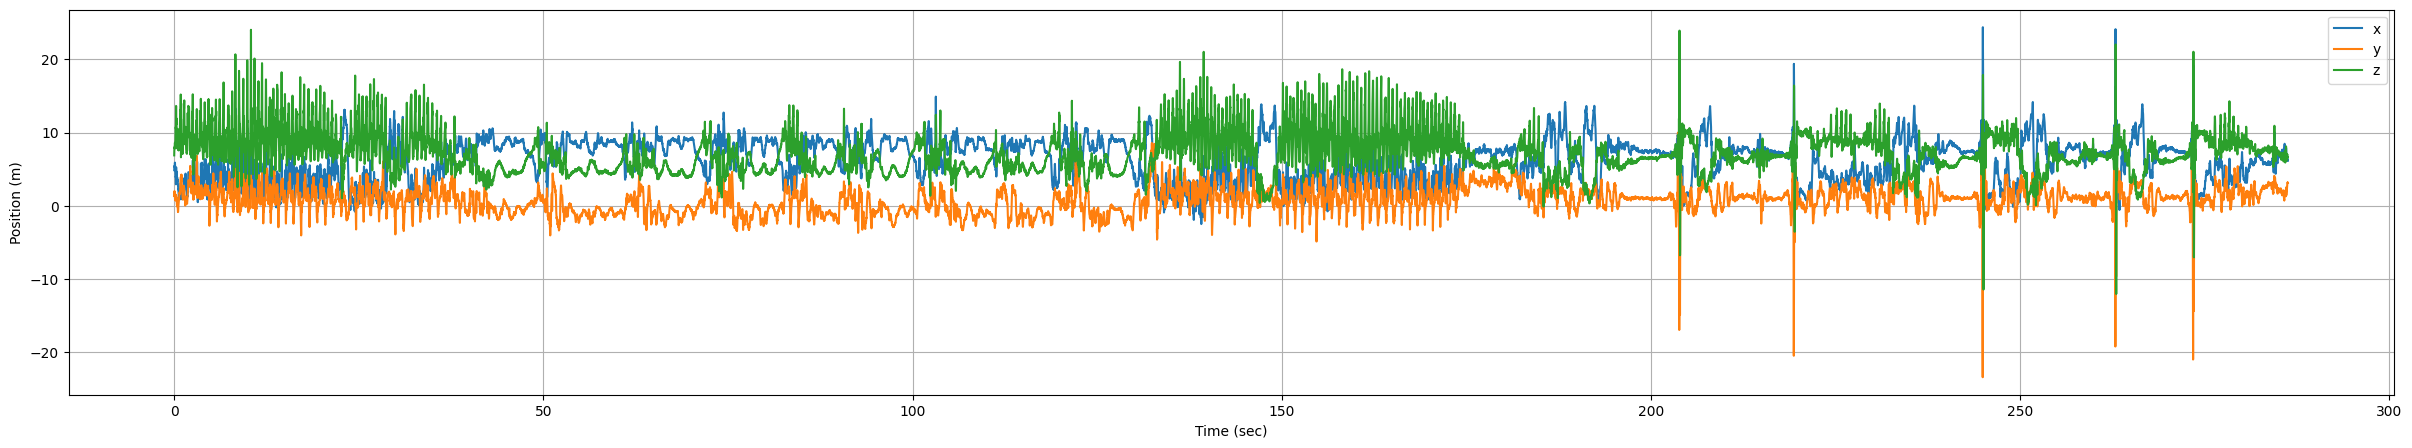

In [103]:
plt.figure(figsize=(30, 5))
plt.plot(poses[:, 0]/1000, poses[:, 1], label='x')
plt.plot(poses[:, 0]/1000, poses[:, 2], label='y')
plt.plot(poses[:, 0]/1000, poses[:, 3], label='z')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Position (m)')
plt.grid()
plt.show()

In [117]:
import numpy as np

class IMUEKF:
    def __init__(self, dt):
        """
        Initialize the Extended Kalman Filter for IMU data.

        Parameters:
        - dt: Time interval between measurements.
        """
        self.dt = dt  # Time step

        # State vector [x, y, z, vx, vy, vz, roll, pitch, yaw]
        self.x = np.zeros((9, 1))

        # State covariance matrix
        self.P = np.eye(9) * 0.1

        # Process noise covariance matrix
        self.Q = np.eye(9) * 0.1

        # Measurement noise covariance matrix
        self.R = np.diag([0.02, 0.02, 0.02, 0.5, 0.5, 0.5]) ** 2

        # Identity matrix
        self.I = np.eye(9)

    def predict(self, u):
        """
        Prediction step of the EKF.

        Parameters:
        - u: Control input vector [ax, ay, az, omega_x, omega_y, omega_z]
        """
        # Extract control inputs
        ax, ay, az, omega_x, omega_y, omega_z = u.flatten()

        # State transition matrix F
        F = np.eye(9)
        F[0, 3] = self.dt
        F[1, 4] = self.dt
        F[2, 5] = self.dt

        # Control input matrix B
        B = np.zeros((9, 6))
        dt2_div_2 = 0.5 * self.dt ** 2
        B[0, 0] = dt2_div_2
        B[1, 1] = dt2_div_2
        B[2, 2] = dt2_div_2
        B[3, 0] = self.dt
        B[4, 1] = self.dt
        B[5, 2] = self.dt
        B[6, 3] = self.dt
        B[7, 4] = self.dt
        B[8, 5] = self.dt

        # Control input vector
        u_vec = np.array([[ax], [ay], [az], [omega_x], [omega_y], [omega_z]])

        # Predict the next state
        self.x = F @ self.x + B @ u_vec

        # Predict the state covariance
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        """
        Update step of the EKF.

        Parameters:
        - z: Measurement vector [ax, ay, az, omega_x, omega_y, omega_z]
        """
        # Measurement function h(x)
        hx = self.measurement_function(self.x)

        # Compute the Jacobian matrix H
        H = self.compute_jacobian(self.x)

        # Measurement residual
        y = z - hx

        # Residual covariance
        S = H @ self.P @ H.T + self.R

        # Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)

        # Update the state estimate
        self.x = self.x + K @ y

        # Update the covariance estimate
        self.P = (self.I - K @ H) @ self.P

    def measurement_function(self, x):
        """
        Nonlinear measurement function h(x).

        Parameters:
        - x: State vector.

        Returns:
        - hx: Expected measurement vector.
        """
        # Extract orientation angles
        roll, pitch, yaw = x[6, 0], x[7, 0], x[8, 0]

        # Rotation matrix from body frame to inertial frame
        R_ib = self.rotation_matrix(roll, pitch, yaw)

        # Assuming no external forces, the measured acceleration is due to gravity
        g = np.array([[0], [0], [9.81]])
        a_meas = R_ib.T @ g

        # Measured angular velocities are the rates (assuming direct measurement)
        omega_meas = np.array([[x[6, 0]], [x[7, 0]], [x[8, 0]]])

        # Concatenate to form hx
        hx = np.vstack((a_meas, omega_meas))

        return hx

    def compute_jacobian(self, x):
        """
        Compute the Jacobian matrix H of the measurement function h(x).

        Parameters:
        - x: State vector.

        Returns:
        - H: Jacobian matrix.
        """
        # Initialize H
        H = np.zeros((6, 9))

        # Extract orientation angles
        roll, pitch, yaw = x[6, 0], x[7, 0], x[8, 0]

        # Compute partial derivatives of acceleration wrt roll, pitch, yaw
        # For simplicity, we use small-angle approximations
        H[0:3, 6:9] = self.acceleration_jacobian(roll, pitch, yaw)

        # Partial derivatives of angular velocities wrt roll, pitch, yaw
        H[3, 6] = 1
        H[4, 7] = 1
        H[5, 8] = 1

        return H

    def rotation_matrix(self, roll, pitch, yaw):
        """
        Compute the rotation matrix from body frame to inertial frame.

        Parameters:
        - roll, pitch, yaw: Orientation angles.

        Returns:
        - R: Rotation matrix.
        """
        roll, pitch, yaw = np.deg2rad(roll), np.deg2rad(pitch), np.deg2rad(yaw)

        # Compute rotation matrices
        R_roll = np.array([
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll), np.cos(roll)]
        ])

        R_pitch = np.array([
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)]
        ])

        R_yaw = np.array([
            [np.cos(yaw), -np.sin(yaw), 0],
            [np.sin(yaw), np.cos(yaw), 0],
            [0, 0, 1]
        ])

        # Combined rotation matrix
        R = R_yaw @ R_pitch @ R_roll

        return R

    def acceleration_jacobian(self, roll, pitch, yaw):
        """
        Compute the Jacobian of the acceleration measurement wrt roll, pitch, yaw.

        Parameters:
        - roll, pitch, yaw: Orientation angles.

        Returns:
        - Ja: Jacobian matrix (3x3).
        """
        roll, pitch, yaw = np.deg2rad(roll), np.deg2rad(pitch), np.deg2rad(yaw)

        # For simplicity, we'll assume small angles and linearize
        # Partial derivatives of acceleration due to gravity
        g = 9.81
        Ja = np.zeros((3, 3))
        Ja[0, 1] = g * np.cos(pitch)
        Ja[1, 0] = -g * np.cos(roll)
        Ja[2, 0] = g * np.sin(roll)
        Ja[2, 1] = g * np.sin(pitch)

        return Ja

    def get_state(self):
        """
        Get the current state estimate.

        Returns:
        - x: Current state vector.
        """
        return self.x.flatten()



# Create an instance of the EKF with the appropriate time step
dt = 0.005  # Example time step in seconds
ekf = IMUEKF(dt)

poses = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    # Extract control inputs from the data
    ax = row['accl_x']
    ay = row['accl_y']
    az = row['accl_z']
    omega_x = row['gyro_x']
    omega_y = row['gyro_y']
    omega_z = row['gyro_z']

    u = np.array([[ax], [ay], [az], [omega_x], [omega_y], [omega_z]])

    # Perform the prediction step
    ekf.predict(u)

    # Assume measurements are the same as control inputs for this example
    z = np.array([[ax], [ay], [az], [omega_x], [omega_y], [omega_z]])

    # Perform the update step
    ekf.update(z)

    # Get the current state estimate
    state = ekf.get_state()
    x, y, z_pos, vx, vy, vz, roll, pitch, yaw = state
    poses.append([row['canonical_timestamp_ms'], x, y, z_pos, roll, pitch, yaw])

    # Print or store the estimated pose
    # print(f"Position: ({x:.2f}, {y:.2f}, {z_pos:.2f}), Orientation: (Roll: {roll:.2f}, Pitch: {pitch:.2f}, Yaw: {yaw:.2f})")

poses = np.array(poses)


  0%|          | 0/56231 [00:00<?, ?it/s]

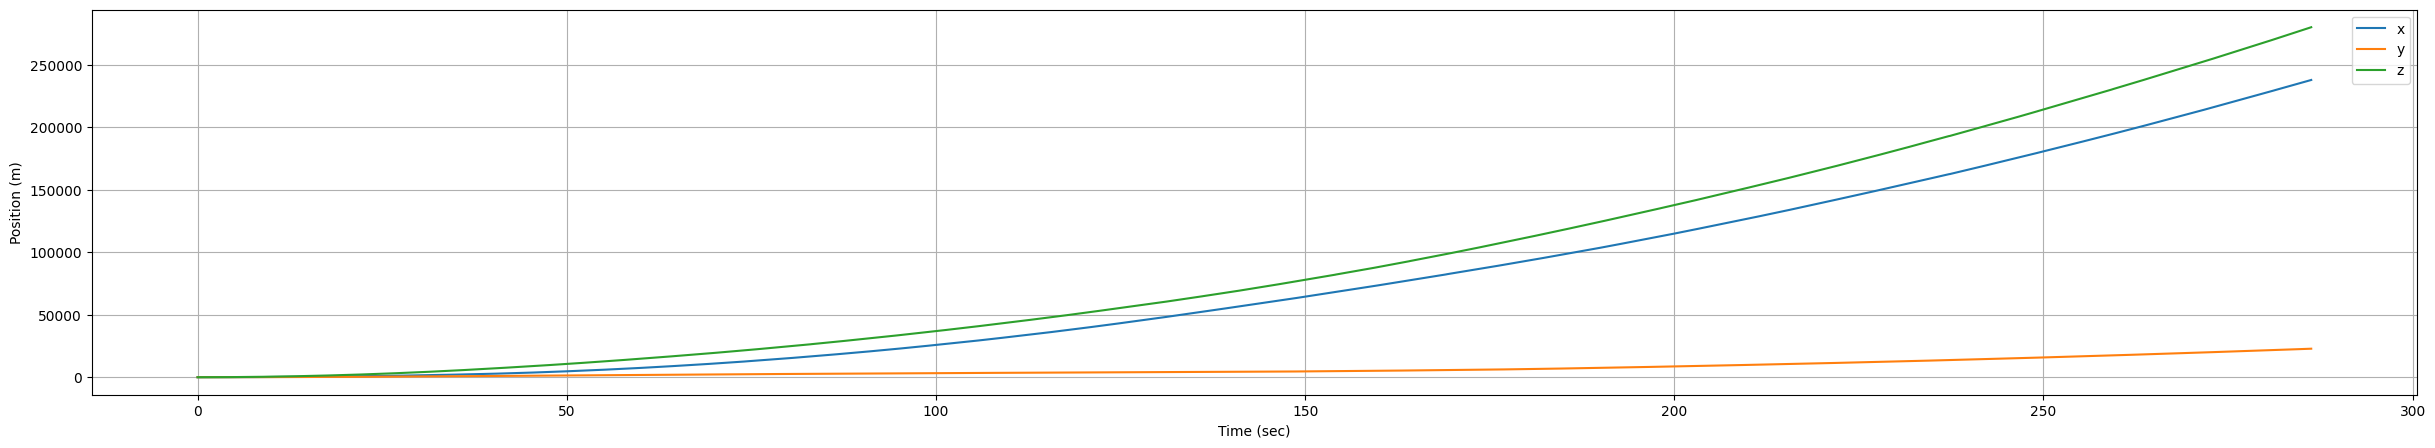

In [118]:
plt.figure(figsize=(30, 5))
plt.plot(poses[:, 0]/1000, poses[:, 1], label='x')
plt.plot(poses[:, 0]/1000, poses[:, 2], label='y')
plt.plot(poses[:, 0]/1000, poses[:, 3], label='z')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Position (m)')
plt.grid()
plt.show()

In [172]:
import numpy as np
from scipy.spatial.transform import Rotation as R

class IMUEKF:
    def __init__(self, dt):
        """
        Initialize the Extended Kalman Filter for IMU data.

        Parameters:
        - dt: Time interval between measurements.
        """
        self.dt = dt  # Time step

        # State vector [position (3), velocity (3), orientation quaternion (4)]
        self.x = np.zeros((10, 1))
        self.x[6:] = np.array([[0], [0], [0], [1]])  # Initial orientation as quaternion

        # State covariance matrix
        self.P = np.eye(10) * 0.1

        # Process noise covariance matrix
        self.Q = np.eye(10) * 0.01

        # Measurement noise covariance matrix
        self.R = np.eye(6) * 0.1

        # Gravity vector in inertial frame (assuming ENU frame with z pointing up)
        self.g = np.array([[0], [0], [-9.81]])  # Gravity acts downward in inertial frame

        # Identity matrix
        self.I = np.eye(10)

    def predict(self, accel_meas, gyro_meas):
        """
        Prediction step of the EKF.

        Parameters:
        - accel_meas: Measured acceleration in body frame (numpy array of shape (3,))
        - gyro_meas: Measured angular velocity in body frame (degrees per second)
        """
        # Convert gyroscope measurements from degrees/sec to radians/sec
        # gyro_meas_rad = np.deg2rad(gyro_meas)
        gyro_meas_rad = gyro_meas

        # Extract state components
        position = self.x[0:3, 0]
        velocity = self.x[3:6, 0]
        quat = self.x[6:10, 0]

        # Convert quaternion to rotation object
        orientation = R.from_quat(quat)

        # Update orientation with gyroscope measurements
        omega = gyro_meas_rad * self.dt  # Angular increment in radians
        delta_orientation = R.from_rotvec(omega)
        orientation = orientation * delta_orientation

        # Update quaternion in state vector
        quat = orientation.as_quat()
        self.x[6:10, 0] = quat

        # Rotate acceleration to inertial frame
        accel_inertial = orientation.apply(accel_meas)

        # Add gravity (since gravity acts downward in inertial frame)
        accel_inertial += self.g.flatten()

        # Update velocity and position
        velocity += accel_inertial * self.dt
        position += velocity * self.dt + 0.5 * accel_inertial * self.dt ** 2

        # Update state vector
        self.x[0:3, 0] = position
        self.x[3:6, 0] = velocity

        # Compute the state transition Jacobian F
        F = self.compute_F(accel_meas, gyro_meas_rad, orientation)

        # Update the state covariance
        self.P = F @ self.P @ F.T + self.Q

    def update(self, accel_meas, gyro_meas):
        """
        Update step of the EKF.

        Parameters:
        - accel_meas: Measured acceleration in body frame (numpy array of shape (3,))
        - gyro_meas: Measured angular velocity in body frame (degrees per second)
        """
        # Convert gyroscope measurements from degrees/sec to radians/sec
        # gyro_meas_rad = np.deg2rad(gyro_meas)
        gyro_meas_rad = gyro_meas

        # Measurement prediction
        z_pred = np.zeros((6, 1))

        # Expected accelerometer measurement
        quat = self.x[6:10, 0]
        orientation = R.from_quat(quat)
        accel_pred = orientation.inv().apply(self.g.flatten())  # Rotate gravity into body frame

        z_pred[0:3, 0] = accel_pred

        # Expected gyroscope measurement (assuming no bias and direct measurement)
        # In this simple model, we assume the angular velocity is zero (since it's accounted for in the prediction step)
        z_pred[3:6, 0] = np.zeros(3)

        # Actual measurements
        z_meas = np.hstack((accel_meas, gyro_meas_rad)).reshape(6, 1)

        # Measurement residual
        y = z_meas - z_pred

        # Compute measurement Jacobian H
        H = self.compute_H(orientation)

        # Compute residual covariance
        S = H @ self.P @ H.T + self.R

        # Compute Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)

        # Update state estimate
        self.x = self.x + K @ y

        # Normalize the quaternion
        quat = self.x[6:10, 0]
        quat /= np.linalg.norm(quat)
        self.x[6:10, 0] = quat

        # Update covariance estimate
        self.P = (self.I - K @ H) @ self.P

    def compute_F(self, accel_meas, gyro_meas_rad, orientation):
        """
        Compute the state transition Jacobian F.

        Parameters:
        - accel_meas: Measured acceleration in body frame.
        - gyro_meas_rad: Measured angular velocity in radians per second.
        - orientation: Current orientation as a Rotation object.

        Returns:
        - F: Jacobian matrix of the state transition function.
        """
        F = np.eye(10)

        # Partial derivatives of position w.r.t velocity
        F[0:3, 3:6] = self.dt * np.eye(3)

        # Partial derivatives of velocity w.r.t orientation (due to rotation)
        R_matrix = orientation.as_matrix()
        skew_accel = self.skew_symmetric(R_matrix @ accel_meas)
        F[3:6, 6:9] = -self.dt * skew_accel

        return F

    def compute_H(self, orientation):
        """
        Compute the measurement Jacobian H.

        Parameters:
        - orientation: Current orientation as a Rotation object.

        Returns:
        - H: Jacobian matrix of the measurement function.
        """
        H = np.zeros((6, 10))

        # Jacobian of accelerometer measurements w.r.t orientation
        R_transpose = orientation.inv().as_matrix()
        skew_g = self.skew_symmetric(self.g.flatten())
        H[0:3, 6:9] = -R_transpose @ skew_g

        # Jacobian of gyroscope measurements w.r.t orientation
        # For simplicity, we assume no dependency, so this remains zeros

        return H

    def skew_symmetric(self, v):
        """
        Compute the skew-symmetric matrix of a vector.

        Parameters:
        - v: A 3-element vector.

        Returns:
        - S: The 3x3 skew-symmetric matrix.
        """
        S = np.array([
            [0, -v[2], v[1]],
            [v[2], 0, -v[0]],
            [-v[1], v[0], 0]
        ])
        return S

    def get_state(self):
        """
        Get the current state estimate.

        Returns:
        - position: Estimated position (numpy array of shape (3,))
        - velocity: Estimated velocity (numpy array of shape (3,))
        - orientation: Estimated orientation as Euler angles (roll, pitch, yaw in degrees)
        """
        position = self.x[0:3, 0]
        velocity = self.x[3:6, 0]
        quat = self.x[6:10, 0]
        orientation = R.from_quat(quat).as_euler('xyz', degrees=True)
        return position, velocity, orientation


In [173]:
data = df.copy()

data['timestamp'] = data['canonical_timestamp_ms'] / 1000.0  # Convert ms to seconds
data['delta_t'] = data['timestamp'].diff().fillna(0.05)  # Estimate dt if first value is missing

# Create an instance of the EKF with the appropriate initial time step
dt_initial = data['delta_t'].iloc[1]
ekf = IMUEKF(dt_initial)

# Initialize lists to store results
positions = []
velocities = []
orientations = []

# Loop over the data
poses = []
for index, row in tqdm(data.iterrows(), total=len(data)):
    # Update time step
    ekf.dt = row['delta_t']

    # Extract IMU measurements
    accel_meas = np.array([row['accl_x'], row['accl_y'], row['accl_z']])
    gyro_meas = np.array([row['gyro_x'], row['gyro_y'], row['gyro_z']])
    # gyro_meas = np.deg2rad(gyro_meas)  # Convert to radians

    # Prediction step
    ekf.predict(accel_meas, gyro_meas)

    # Update step
    ekf.update(accel_meas, gyro_meas)

    # Get the current state estimate
    position, velocity, orientation = ekf.get_state()

    # Store the results
    positions.append(position)
    velocities.append(velocity)
    orientations.append(orientation)

    # Optional: Print or plot the estimated pose
    # print(f"Time: {row['timestamp']:.2f}s, Position: {position}, Orientation (Roll, Pitch, Yaw): {orientation}")
    poses.append([row['timestamp'], *position, *orientation])

# Convert results to arrays for further analysis or plotting
positions = np.array(positions)
velocities = np.array(velocities)
orientations = np.array(orientations)
poses = np.array(poses)


  0%|          | 0/56212 [00:00<?, ?it/s]

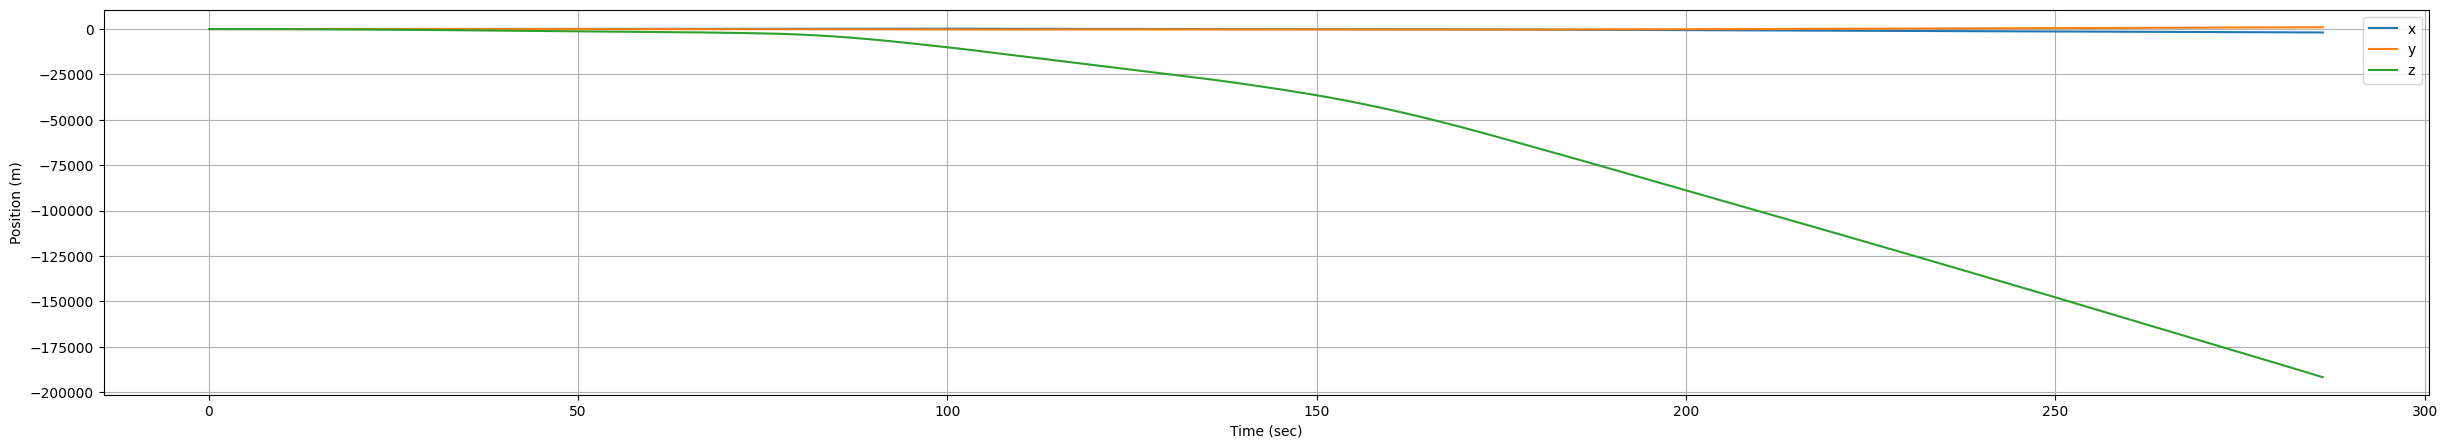

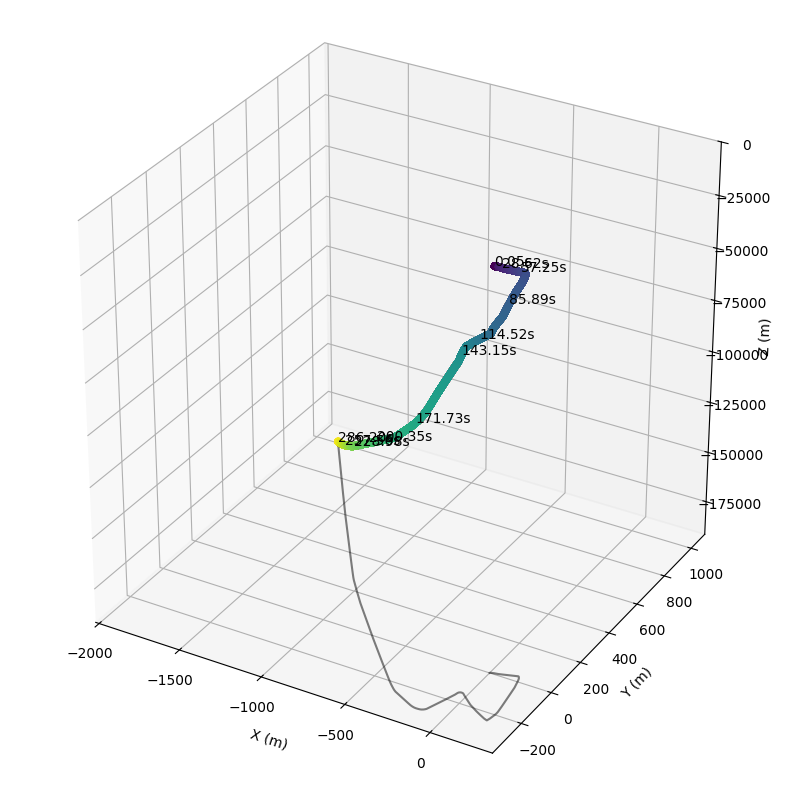

In [180]:
poses = np.array(poses)
plt.figure(figsize=(30, 5))
plt.plot(poses[:, 0], poses[:, 1], label='x')
plt.plot(poses[:, 0], poses[:, 2], label='y')
plt.plot(poses[:, 0], poses[:, 3], label='z')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Position (m)')
plt.grid()
plt.show()


# plot 3D trajectory as scatters with alpha evolveing with time
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(poses[:, 1], poses[:, 2], poses[:, 3], c=poses[:, 0], cmap='viridis', alpha=0.5)
# proj on x-y plane
ax.set_zlim(poses[:, 3].min(), poses[:, 3].max())
ax.plot(poses[:, 1], poses[:, 2], zs=poses[:, 3].min(), color='black', alpha=0.5)
# mark a few time points with text
for i in range(0, len(poses), len(poses) // 10):
    ax.text(poses[i, 1], poses[i, 2], poses[i, 3], f'{poses[i, 0]:.2f}s', color='black')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
# equal distances on axes
ax.set_box_aspect([1, 1, 1])
plt.show()


Compounding the animation...


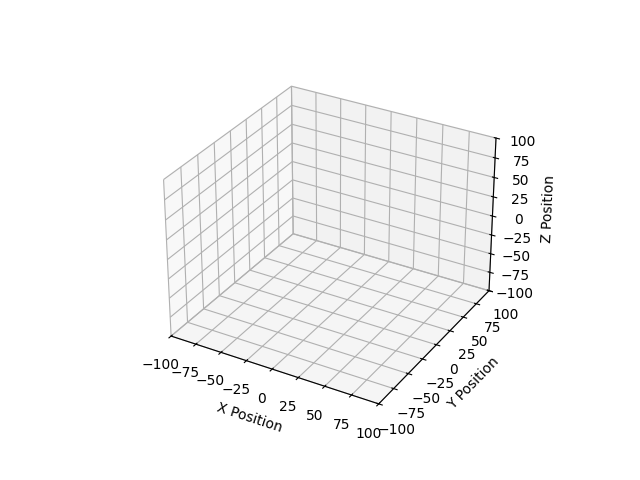

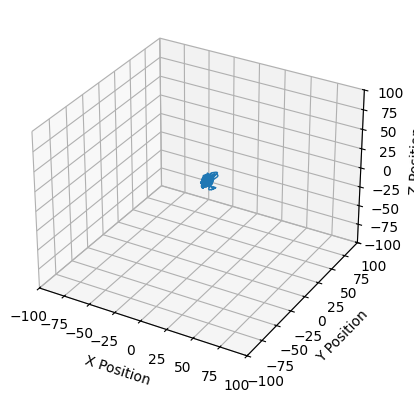

In [59]:



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-100, 100])
ax.set_ylim([-100, 100])
ax.set_zlim([-100, 100])
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

# Line object to update
trajectory, = ax.plot([], [], [], lw=1)

# Initialization function for FuncAnimation
# def init():
#     trajectory.set_data([], [])
#     trajectory.set_3d_properties([])

#     return trajectory,

# Update function for real-time plotting
def update(frame):
    # xdata = position[:frame, 0]
    # ydata = position[:frame, 1]
    # zdata = position[:frame, 2]

    # trajectory.set_data(xdata, ydata)
    # trajectory.set_3d_properties(zdata)
    trajectory.set_data_3d(poses[:frame, 1:4].T)

    return trajectory,

# Create animation
anim = FuncAnimation(fig, update, frames=range(0, 5000, 10), blit=True)
print('Compounding the animation...')
anim.save('/tmp/imuimu.gif', fps=24, writer='imagemagick')
IPImage('/tmp/imuimu.gif')